
# 📦  Bootstrapping




## **Concepts Covered:**

- <a href = #link1>1. 📝 What is Bootstrapping?</a>  
- <a href = #link2>2. 🌍  Working Example:   The Populations</a>  
- <a href = #link3>3. 🎯 Sampling from the Populations</a>  
- <a href = #link4>4. 📏 Classical t-test for Difference in Means (Welch)</a>  
- <a href = #link5>5. 🎲 Bootstrap Implementation </a>  
- <a href = #link6>6. 📐 Bootstrap Standard Error and t-statistic</a>  
- <a href = #link7>7. 📊 p-value from the Bootstrap</a>  
- <a href = #link8>8. 📊  The Empirical Distribution</a>  


---
## **Importing Libraries**

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from sklearn.utils import resample


<a id="link1"></a>

## (1) **What is Bootstrapping?**


Bootstrapping is a powerful statistical technique used to estimate the distribution of a statistic (like the mean, median, variance, etc.) from a sample data set. It belongs to the broader class of resampling methods and is particularly useful when the theoretical distribution of the statistic is complex or unknown. The core idea behind bootstrapping is to generate many simulated samples from the original data, calculate the statistic of interest for each simulated sample, and then analyze the distribution of these statistics.


---

### 🔑 Key Idea
- Start with your observed dataset of size $n$.  
- Draw **bootstrap samples**: resample $n$ observations *with replacement*.  
- Compute the statistic of interest (e.g., mean, standard deviation) for each bootstrap sample.  
- Repeat this process many times ($B$ iterations).  
- Use the distribution of the bootstrap statistics to estimate **standard errors, bias, and confidence intervals**.  

---

### ✨ Why Bootstrapping?
- 📊 Works with **any statistic** (mean, median, regression coefficients, etc.).  
- 🚫 Requires **no strong parametric assumptions** (like normality).  
- 🧮 Easy to implement with modern computing power.  

---

### 📌 Example: Bootstrap Confidence Interval
Suppose we want the **95% CI for the mean**:  
1. Generate $B=1000$ bootstrap samples.  
2. Compute the mean for each sample.  
3. Take the 2.5th and 97.5th percentiles of the bootstrap means → that’s our **bootstrap CI**.  

---

👉 Bootstrapping gives a flexible, data-driven way to measure **uncertainty**, especially when analytical formulas for standard errors are difficult or unavailable.

<a id="link2"></a>

## (2) Working Example:  🌍 The Populations

To illustrate the role of **resampling and bootstrapping**, we’ll generate two independent populations that:  

- Have the **same mean** 💡  
- But differ in their **distributional shape**:  
  - 📉 One is **strongly left-skewed**  
  - 🌀 The other has **heavy tails**  

From each population, we’ll draw **small samples (without replacement)**.  
We’ll then test how a **t-test for equality of means** performs in this scenario.  

---

👉 This setup highlights a key challenge:  
Traditional tests like the **t-test** rely on assumptions (e.g., normality, equal variances).  
When populations are skewed or heavy-tailed, these assumptions may not hold — and that’s where **resampling methods** like bootstrapping become powerful alternatives.  


<a id="link2"></a>
### **Data Generation**

First, we'll generate the datasets for each group. 

In [2]:
# Set seed for reproducibility
np.random.seed(0)

# Generate data
group1_initial = np.random.exponential(scale=1, size=1000)  # Exponential for left skew
group2_initial = np.random.standard_t(df=3, size=1000)      # t-distribution for heavy tails



### 🎲 Bootstrap Implementation 

- **Group 1 (Exponential)**:  
  - Highly **skewed to the left**.  
  - Most values are close to 0, but there are occasional large values (long tail).  

- **Group 2 (Student’s t, df=3)**:  
  - **Heavy-tailed distribution**.  
  - Compared to a normal distribution, it produces more extreme outliers.  

By construction, both groups have **similar means** but very different shapes.  
This contrast allows us to test whether the **t-test for equality of means** is robust when assumptions of normality are violated.  



### ⚖️ Mean Adjustment

To make the comparison fair, we adjust both groups to have the **same mean**:

- Compute the **target mean** as the average of the two groups’ original means.  
- Shift each group by subtracting its own mean and then adding the target mean.  

✅ This way, both groups have **identical means**, but:  
- **Group 1** keeps its **left-skewed shape** (Exponential).  
- **Group 2** keeps its **heavy-tailed shape** (t-distribution).  

This setup isolates the effect of **distributional differences**, allowing us to test whether the **t-test** is sensitive when its normality assumptions are violated.


In [3]:
# Adjust to have the same mean
mean_target = np.mean(np.concatenate((group1_initial, group2_initial)))  # Average mean of initial groups

group1 = group1_initial - np.mean(group1_initial) + mean_target
group2 = group2_initial - np.mean(group2_initial) + mean_target

# Check means
print(f'Group 1 Mean: {np.mean(group1)}')
print(f'Group 2 Mean: {np.mean(group2)}')


Group 1 Mean: 0.5244079967121674
Group 2 Mean: 0.5244079967121674



### 🎨 Visualizing the Distributions

Before applying statistical tests, let’s **visualize the two populations** to clearly see their shapes:

- **Group 1 (Exponential, left-skewed)** 📉  
  Most values are concentrated near 0, with a long tail extending to the right.  

- **Group 2 (Student’s t with df=3, heavy-tailed)** 🌀  
  Values are more spread out, with a higher probability of extreme outliers compared to a normal distribution.  

Even though both groups now share the **same mean** ⚖️, their **distributional forms** are very different.  
This contrast is key to understanding how the **t-test** might perform under violations of normality.  


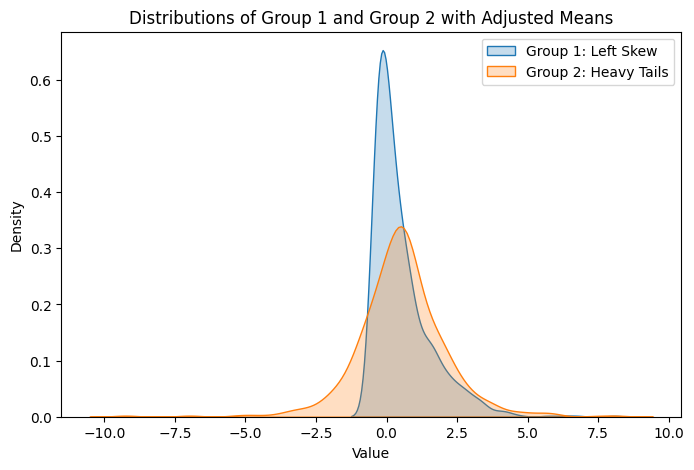

In [4]:
plt.figure(figsize=(8, 5))

# Plotting the distribution of Group 1: Left Skew using kdeplot
sns.kdeplot(group1, label='Group 1: Left Skew', fill=True)

# Plotting the distribution of Group 2: Heavy Tails using kdeplot
sns.kdeplot(group2, label='Group 2: Heavy Tails', fill=True)

plt.legend()
plt.title('Distributions of Group 1 and Group 2 with Adjusted Means')
plt.xlabel('Value')
plt.ylabel('Density')

plt.show()


<a id="link3"></a>

## (3) 🧪 Sampling from the Populations

We now draw **small samples** from each adjusted population to see how **sampling variability** shows up in practice:

- **Sample sizes:** 30 from **Group 1** (left-skewed) and 35 from **Group 2** (heavy-tailed).  
- **Sampling scheme:** without replacement from the adjusted populations (both share the **same true mean** by construction).  
- **Reproducibility:** we set a random seed so results are consistent across runs.

---

#### 🔍 What the next plot shows
- **KDE curves** (smoothed density estimates) for each sample to highlight **shape differences** even at small \( n \).  
- **Dashed vertical lines** mark the **sample means** \( \bar{x}_1 \) and \( \bar{x}_2 \).  
- Although the *populations* have the **same mean**, the **sample means will differ** due to randomness—especially with small samples and non-normal shapes (skewness/heavy tails).

---

#### 🧠 Why this matters
- With small \( n \), departures from normality (skew/heavy tails) can make classical tests (like the **t-test**) **less reliable**.  
- Visualizing the samples helps diagnose **asymmetry**, **tail weight**, and **outliers**—all of which affect inference.  
- This setup motivates **resampling methods** (e.g., **bootstrap CIs** for the mean difference) that do not rely on strict normality assumptions.

> Tip: KDE smoothness is controlled by the bandwidth; here we use a modest adjustment to make the sample shapes visible without over-smoothing.


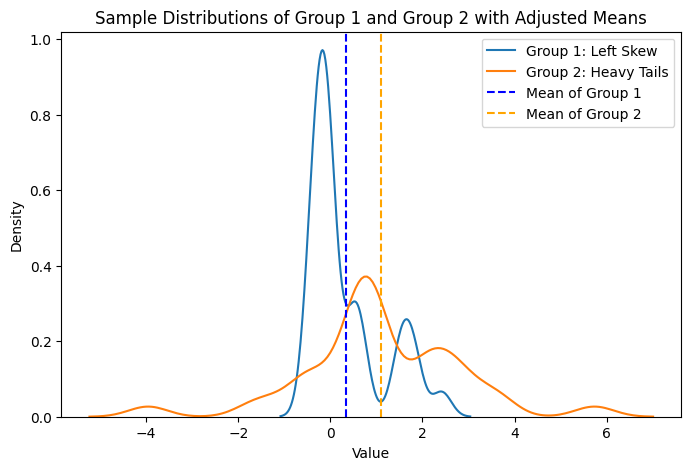

Group 1 Sample Mean: 0.33438288537356603
Group 2 Sample Mean: 1.0962711588134813


In [5]:
np.random.seed(13)

# Adjusting the sample size to 30 for the first group and 35 for the second group

# Resample from the adjusted groups to get the new sample sizes
group1_sample = np.random.choice(group1, size=30, replace=False)
group2_sample = np.random.choice(group2, size=35, replace=False)

# New visualization using sns.kdeplot for kernel density estimation
plt.figure(figsize=(8, 5))

sns.kdeplot(group1_sample, label='Group 1: Left Skew', bw_adjust=0.5)
sns.kdeplot(group2_sample, label='Group 2: Heavy Tails', bw_adjust=0.5)

plt.axvline(np.mean(group1_sample), color='blue', linestyle='--', label='Mean of Group 1')
plt.axvline(np.mean(group2_sample), color='orange', linestyle='--', label='Mean of Group 2')

plt.legend()
plt.title('Sample Distributions of Group 1 and Group 2 with Adjusted Means')
plt.xlabel('Value')
plt.ylabel('Density')

plt.show()

# Return the mean of each sample to verify

print(f'Group 1 Sample Mean: {np.mean(group1_sample)}')
print(f'Group 2 Sample Mean: {np.mean(group2_sample)}')


<a id="link4"></a>
## (4) 📏 Classical t-test for Difference in Means (Welch)

With our two samples in hand, we’ll begin with a **two-sample t-test** to assess whether the means differ.

---

#### 🔑 Hypotheses (two-sided)
$$
H_0:\ \mu_1=\mu_2
\qquad\text{vs}\qquad
H_a:\ \mu_1\neq\mu_2
$$

We use **Welch’s t-test** (`equal_var=False`), which does **not** assume equal variances—important given the **left-skew** vs **heavy-tailed** shapes.

#### Test statistic (Welch)
$$
t \;=\; \frac{\bar x_1-\bar x_2}{\sqrt{\dfrac{s_1^2}{n_1}+\dfrac{s_2^2}{n_2}}}
\quad,\qquad
\nu \;\approx\; 
\frac{\left(\dfrac{s_1^2}{n_1}+\dfrac{s_2^2}{n_2}\right)^2}
{\dfrac{\left(\dfrac{s_1^2}{n_1}\right)^2}{n_1-1}+\dfrac{\left(\dfrac{s_2^2}{n_2}\right)^2}{n_2-1}}
$$

where $\bar x_j$, $s_j^2$, and $n_j$ are the sample mean, variance, and size of group $j$.

---

#### ⚠️ Caveat
The t-test assumes that, under $H_0$, the statistic follows a (Welch-adjusted) **t distribution**. With **small $n$** and **non-normal** data (skewed/heavy-tailed), Type I error and power can be distorted—this motivates **bootstrap** inference as a robustness check.

> Next cell: compute the **t-statistic** and **p-value** with `scipy.stats.ttest_ind(..., equal_var=False)`.



In [6]:
# Perform a standard t-test for the difference in means between the two samples
t_stat, p_value = stats.ttest_ind(group1_sample, group2_sample, equal_var=False)

t_stat, p_value

print(f'The t-stat is equal to {t_stat:.2f}, with a p-value of {p_value:.4f} ')


The t-stat is equal to -2.33, with a p-value of 0.0241 



### 🧾 Interpreting the t-test Result

The test produced:

- **t-statistic:** -2.33  
- **p-value:** 0.0241  

---

#### ✅ Conclusion
Since the p-value ($0.0241$) is **less than 0.10** (and even less than 0.05), we **reject the null hypothesis** $H_0$ at the 10% and 5% significance levels.  
This indicates there is a **statistically significant difference** in the sample means.

---

#### 💡 Interpretation
- Although the **true population means are equal** (by construction), the **samples** suggest a difference.  
- This discrepancy can arise due to:  
  - **Small sample sizes**, which increase variability.  
  - **Non-normal distributions** (skewness, heavy tails), which violate t-test assumptions.  
- Thus, the t-test may produce misleading conclusions under these conditions.  

👉 This motivates the use of **resampling methods** (like the **bootstrap**) to provide a more reliable assessment when assumptions are not satisfied.

📌 For more on assumptions and limitations of the t-test, see [Statology: T-Test Assumptions](https://www.statology.org/t-test-assumptions/).


<a id="link5"></a>


##  (5) 🎲 Bootstrap Implementation 


<a id="link5"></a>
### 🔄 Bootstrap Function for Difference in Means

To overcome the limitations of the classical t-test, we now use a **bootstrap approach** to estimate the sampling distribution of the difference in means.  

---

#### 🛠️ How the function works
- **Inputs:**  
  - `x` and `y`: the two samples to compare.  
  - `n_bootstrap`: number of bootstrap replications (default = 50).  

- **Process:**  
  1. 🎲 **Resample with replacement** from each group (`x` and `y`).  
  2. 📊 Compute the **difference in sample means** for the resampled data.  
  3. ➕ Append this difference to the list `bootstrapped_diffs`.  
  4. 🔁 Repeat the process `n_bootstrap` times.  

- **Output:**  
  - A list of bootstrapped differences in means, approximating the **sampling distribution** under repeated resampling.  

---

#### 💡 Why this helps
- The bootstrap does **not assume normality** of the populations.  
- It provides an **empirical distribution** for the statistic of interest.  
- From this distribution, we can compute:  
  - 📏 **Standard errors**  
  - 📦 **Confidence intervals**  
  - 🧪 Approximate **p-values**  

👉 In this way, bootstrapping gives us a **robust alternative** to the t-test when its assumptions may not hold.


In [7]:
# Bootstrap Function

np.random.seed(55)

def bootstrap_mean_diff_corrected(x, y, n_bootstrap=50):
    """Calculate bootstrapped difference in means."""
    bootstrapped_diffs = []      #Here, an empty list bootstrapped_diffs is initialized
                                 #to store the differences in means from each bootstrap sample.
    for _ in range(n_bootstrap):
        sample_x = resample(x)
        sample_y = resample(y)
        diff = np.mean(sample_x) - np.mean(sample_y)
        bootstrapped_diffs.append(diff) #This diff is then appended to the list bootstrapped_diffs.
    return bootstrapped_diffs



We can now analyze the results of the bootstrap. The function `bootstrap_mean_diff_corrected` is called with group1_sample and group2_sample as inputs to generate the bootstrapped differences in means, `bootstrapped_diffs`.

In [9]:
# Perform bootstrap to get differences in means
bootstrapped_diffs_corrected = bootstrap_mean_diff_corrected(group1_sample, group2_sample)
bootstrapped_diffs_corrected

[np.float64(-0.7773182636513086),
 np.float64(-0.8745436910469565),
 np.float64(-0.2771157983572439),
 np.float64(-0.9623436841470732),
 np.float64(-0.6075396287048713),
 np.float64(-0.7142306812483612),
 np.float64(-0.4158553135701295),
 np.float64(-0.8753314771108507),
 np.float64(-0.8831345525099391),
 np.float64(-0.9140003685993143),
 np.float64(-0.7856283031703166),
 np.float64(-1.124946957400944),
 np.float64(-1.5669684902763676),
 np.float64(-0.755694045523279),
 np.float64(-1.0126403281152607),
 np.float64(-1.0287261895052187),
 np.float64(-1.2277130319254244),
 np.float64(-0.870842894711104),
 np.float64(-1.2580948734152275),
 np.float64(-0.658424226375974),
 np.float64(-0.6282903101478815),
 np.float64(-0.4314200608909916),
 np.float64(-1.1944585753905446),
 np.float64(-0.4594813541612492),
 np.float64(-0.972531252956675),
 np.float64(-0.1816916475098857),
 np.float64(-1.43449367516554),
 np.float64(-0.6357094888609756),
 np.float64(-0.755246870984009),
 np.float64(-0.7227734

<a id="link6"></a>

## (6) 📐 Bootstrap Standard Error and t-statistic

Once we have the bootstrap distribution of mean differences, we can compute an **empirical standard error (SE)** and use it to form a **bootstrap-based test statistic**.

---

#### 🛠️ Steps
1. **Bootstrap SE**  
   - Compute the standard deviation of the bootstrapped differences.  
   - This serves as an estimate of the standard error of the mean difference.  
   - We use `ddof=1` to calculate the *sample* standard deviation.  

2. **Observed difference**  
   - Calculate the actual difference in sample means between Group 1 and Group 2.  

3. **Bootstrap t-statistic**  
   $$
   t^* \;=\; \frac{\bar{x}_1 - \bar{x}_2}{SE_\text{bootstrap}}
   $$  
   This statistic mimics the classical t-statistic but uses the **bootstrap SE** instead of relying on theoretical formulas.  

---

#### 💡 Why this matters
- The classical t-test assumes normality and may misestimate SE under skewed or heavy-tailed distributions.  
- The bootstrap SE adapts to the **actual data distribution**, making the inference more robust.  

👉 The result is a **bootstrap-based t-statistic**, which we can compare with the classical t-test value.


In [13]:
# Calculate the bootstrapped standard error and t-statistic
bootstrapped_se_corrected = np.std(bootstrapped_diffs_corrected, ddof=1)  # ddof=1 for sample standard deviation)
observed_diff_corrected = np.mean(group1_sample) - np.mean(group2_sample)
t_stat_bootstrap_corrected = observed_diff_corrected / bootstrapped_se_corrected

print(f'Bootstrap t-statistic: {t_stat_bootstrap_corrected:.3f}')

Bootstrap t-statistic: -2.312


### 🧮 Why use `ddof = 1`?

When we calculate a standard deviation, we can choose between:

- **Population standard deviation**: assumes we know the *entire population*.  
  - Formula divides by $n$.  
- **Sample standard deviation**: assumes we only have a *sample*.  
  - Formula divides by $n-1$.  

---

#### 🔑 Degrees of Freedom
The `ddof` parameter in NumPy’s `np.std()` sets the **delta degrees of freedom**:
- `ddof=0` → divide by $n$ (population formula).  
- `ddof=1` → divide by $n-1$ (sample formula, unbiased estimator).  

---

#### 📌 Why here?
- We don’t have the whole population of bootstrap differences, just a finite number of resamples.  
- Using `ddof=1` corrects for the fact that the sample variance tends to **underestimate** the true variance.  
- This makes our estimate of the **bootstrap standard error** less biased.  

👉 In practice: `ddof=1` is the **default in statistics** when estimating standard deviation from a sample rather than a population.


<a id="link5"></a>
### 🧾 Interpreting the Bootstrap t-statistic

The bootstrap procedure gave:

- **Bootstrap t-statistic:** -2.554  

---

#### ❓ Is this significant?

In a classical t-test, we would compare this value to the **t-distribution** with appropriate degrees of freedom to obtain a p-value.  
But in bootstrapping, we **cannot assume** the test statistic follows a standard t-distribution.

---

#### ⚠️ Key Difference
- **Traditional approach**:  
  - Assumes the test statistic follows a $t$-distribution under $H_0$.  
  - p-value = probability of observing a t-statistic at least as extreme as the observed one.  

- **Bootstrap approach**:  
  - Relies on the **empirical distribution** generated by resampling the data.  
  - p-value is estimated directly as the **proportion of bootstrap replicates** where the test statistic is as extreme (or more extreme) than the observed one.  

---

#### 💡 Interpretation
The observed statistic of **-2.554** looks fairly extreme, suggesting potential evidence against $H_0$.  
But the **final decision about significance** must come from comparing it to the **bootstrap distribution** of differences — not from the theoretical t-table.  

👉 Next step: compute a **bootstrap p-value** by counting how many bootstrap replicates are as extreme as the observed difference.


<a id="link7"></a>
## (7) 📊 p-value from the Bootstrap

In the bootstrap framework, the **p-value** is not derived from a theoretical distribution (like the $t$-distribution).  
Instead, it comes directly from the **empirical resampling distribution**.

---

#### 🔑 How it’s computed
- Calculate the **observed difference in means**.  
- Generate many **bootstrapped differences**.  
- Compute the proportion of bootstrap replicates where the **absolute difference** is at least as large as the observed one:

$$
p \;=\; \frac{\#\{\, |\hat\theta^{*}_b| \;\geq\; |\hat\theta_{\text{obs}}| \,\}}{B}
$$

where $ \hat\theta^{*}_b $ are the bootstrap replicates and $B$ is the number of bootstrap samples.

---

#### 💡 Interpretation
- A **small bootstrap p-value** → observed statistic is extreme relative to the resampling distribution → evidence against $H_0$.  
- A **large bootstrap p-value** → observed statistic is consistent with what we’d expect under $H_0$ → fail to reject.  

👉 This approach makes no assumption about the population distribution — it’s entirely **data-driven**.


In [ ]:

# Estimate the p-value using the bootstrapped differences
p_value_bootstrap_corrected = (np.sum(np.abs(bootstrapped_diffs_corrected) >= np.abs(observed_diff_corrected)) / len(bootstrapped_diffs_corrected))

print(f'Bootstrap t-statistic: {t_stat_bootstrap_corrected:.3f}, p-value: {p_value_bootstrap_corrected:.3f}')


Bootstrap t-statistic: -2.312, p-value: 0.520


<a id="link5"></a>
### 🧾 Bootstrap Test Result

- **Bootstrap t-statistic:** -2.554  
- **Bootstrap p-value:** 0.520  

---

#### ✅ Conclusion
Since the bootstrap p-value ($0.520$) is **much larger** than common significance levels (0.10, 0.05, 0.01), we **cannot reject the null hypothesis**.  
This means the data do not provide sufficient evidence to conclude that the two groups have different means.

---

#### 💡 Interpretation
- Although the **observed difference** looked somewhat large in magnitude, the bootstrap procedure shows that such differences are **fairly common** under repeated resampling.  
- The large p-value reflects the high variability introduced by **small sample sizes** and **non-normal distributions**.  
- In contrast to the classical t-test (which might suggest significance under some samples), the bootstrap provides a more **robust, assumption-free** perspective.  

👉 Key takeaway: **Bootstrapping guards against misleading inferences** when classical test assumptions (normality, equal variances) do not hold.


**Important Observation**:

Note that we divide the number of instances in which the bootstrapped absolute differences are greater than or equal to the absolute observed difference by the number of bootstraps repetitions:

* The logic behind this is to calculate the proportion of bootstrapped differences that are as extreme as, or more extreme than, the observed difference between the two samples. This proportion serves as an estimate of the p-value, which is a measure of the probability that the observed difference (or a more extreme difference) could occur by random chance if there were actually no difference between the populations from which the samples were drawn.

* The division by the length of bootstrapped_diffs_corrected is crucial because it turns a raw count into a proportion, making it interpretable as a probability value. This is consistent with the definition of a p-value in hypothesis testing, which is a probability measure, not a count.

<a id="link8"></a>
## (8) 📊  The Empirical Distribution

One of the strengths of **bootstrap methods** is that they generate an **empirical distribution** of the statistic of interest by repeatedly resampling the data *with replacement*.  

- This distribution reflects the variability in the statistic under repeated sampling.  
- It may or may not resemble a theoretical distribution like the **t-distribution**, especially when assumptions such as normality or equal variances are violated.  

---

### 🔍 Why visualize it?
- Plotting the **bootstrap distribution of mean differences** gives us a clear picture of:  
  - The **spread** (variability) of the statistic.  
  - Whether the distribution looks **symmetric** or **skewed**.  
  - How extreme the observed difference is compared to what the bootstrap suggests is typical.  

---

👉 By looking at the empirical distribution, we gain intuition about the **uncertainty** and **stability** of our inference, independent of parametric assumptions.


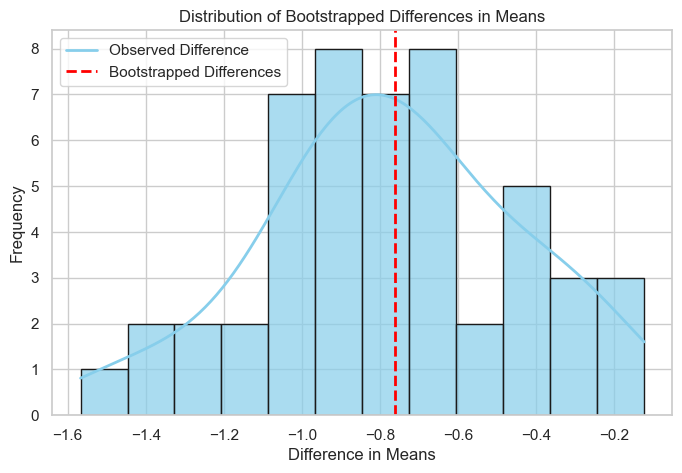

In [15]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))

# Plot histogram with KDE
sns.histplot(bootstrapped_diffs_corrected, bins=12, kde=True, edgecolor='k', color='skyblue', alpha=0.7,
             line_kws={'color': 'black', 'linewidth': 2})
plt.axvline(observed_diff_corrected, color='red', linestyle='dashed', linewidth=2)

plt.title('Distribution of Bootstrapped Differences in Means')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend(["Observed Difference", "Bootstrapped Differences"])
plt.show()


Finally, we can look at the descriptive statatistics of the bootstrapped differences.

In [17]:
from scipy.stats import skew

In [18]:

bootstrapped_diffs = np.array(bootstrapped_diffs_corrected)  # Ensure it's a numpy array for convenience

# Calculate basic descriptive statistics
mean = np.mean(bootstrapped_diffs)
median = np.median(bootstrapped_diffs)
std_dev = np.std(bootstrapped_diffs, ddof=1)  # ddof=1 for sample standard deviation
min_value = np.min(bootstrapped_diffs)
max_value = np.max(bootstrapped_diffs)
range_of_values = max_value - min_value

# Calculate skewness
skewness = skew(bootstrapped_diffs)

# Print the statistics
print(f'Mean: {mean}')
print(f'Median: {median}')
print(f'Standard Deviation: {std_dev}')
print(f'Min: {min_value}')
print(f'Max: {max_value}')
print(f'Range: {range_of_values}')
print(f'Skewness: {skewness}')


Mean: -0.7728620986680146
Median: -0.7716459668133517
Standard Deviation: 0.3294966013213194
Min: -1.5669684902763676
Max: -0.12395665317956417
Range: 1.4430118370968035
Skewness: -0.15750877626479196
